## Exploratory data analysis of the Foursquare restaurant data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from numpy import median
import folium

First, I'll read in the neighborhood data

In [2]:
neighbor_df = pd.read_csv('processed/restaurant_data.csv')
neighbor_df.drop('Unnamed: 0', axis=1, inplace=True)
neighbor_df.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue_ID,Venue LonLat,Total Likes,Venue Category
0,Adams-Normandie,34.031398,-118.300301,Ignatius Cafe,4fa1ba91e4b0e852a4072ac2,POINT (-118.2930062234196 34.03177152787079),17,Café
1,Adams-Normandie,34.031398,-118.300301,Bird's Nest Cafe,57dd8298498ee69b670f8bb9,POINT (-118.2916379696774 34.03443378381787),10,Restaurant
2,Adams-Normandie,34.031398,-118.300301,Orange Door Sushi,5498d200498e8153c17c751a,POINT (-118.299540608008 34.03226985807376),6,Sushi Restaurant
3,Adams-Normandie,34.031398,-118.300301,Himalayan House,579d85f4498ef5970ff133f7,POINT (-118.2942092848373 34.02578528424605),11,Himalayan Restaurant
4,Adams-Normandie,34.031398,-118.300301,Caveman Kitchen,4b8bb46cf964a520b6a732e3,POINT (-118.291991746519 34.03582259149761),27,South American Restaurant


What are the 10 most common restaurants in LA (based on our neighborhood sampling method)?

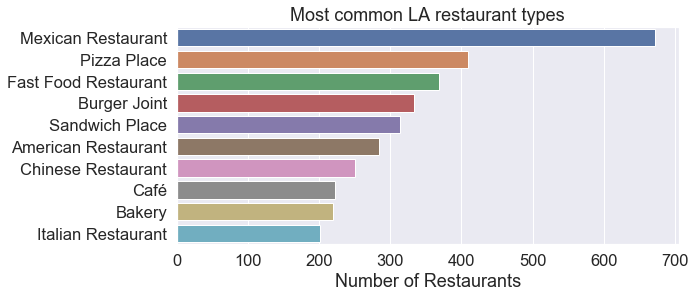

In [3]:
la_counts = neighbor_df.groupby('Venue Category')[['Venue Category']].count()
la_counts.columns = ['counts']
la_count_sorted = la_counts.sort_values('counts', ascending=False).head(10).transpose()
sns.set(style="whitegrid")
tips = pd.melt(la_count_sorted.reset_index(), id_vars=["index"], value_vars=la_count_sorted.columns)
plt.figure(figsize=(9,4))
sns.set(font_scale = 1.5)
ax = sns.barplot(y="Venue Category", x="value", data=tips)
ax.set_ylabel('', fontsize=15)
ax.set_xlabel("Number of Restaurants")
ax.set_title("Most common LA restaurant types")
fig = ax.get_figure()
fig.savefig('most_common_rest.png',dpi=600,bbox_inches="tight") 


Mexican, pizza, and fast food restaurants are most common in LA based on our neighborhood level sampling technique.

Next, what restaurants in LA have the most total likes (again sampled by neighborhood)?

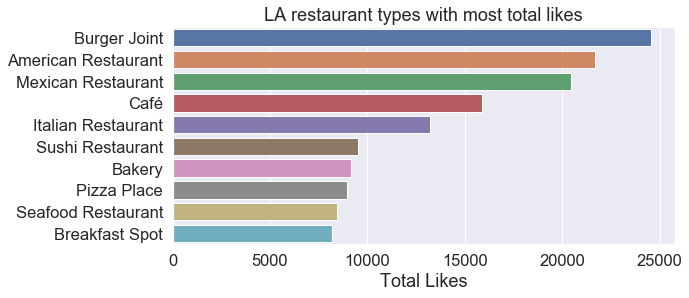

In [4]:
plot_data = neighbor_df.reset_index()[['Venue Category','Total Likes']]
plot_data2 = neighbor_df[['Venue Category','Total Likes']].groupby('Venue Category').sum()
top_venues = plot_data2.sort_values('Total Likes',ascending=False).head(10)
plt.figure(figsize=(9,4))
sns.set(font_scale = 1.5)
ax = sns.barplot(y="Venue Category", x="Total Likes", data=top_venues.reset_index())
ax.set_ylabel('')
ax.set_title("LA restaurant types with most total likes")
fig = ax.get_figure()
fig.savefig('total_likes.png',dpi=600,bbox_inches="tight") 

Burger joints lead in total likes, with nearly 25000 likes in this sampling.

What is the distribution of likes per restaurant (summary statistics and a histogram)?

In [5]:
neighbor_df[['Total Likes']].describe()

,Total Likes
count,6438.000000
mean,44.598478
std,98.097556
min,0.000000
25%,6.000000
50%,15.000000
75%,43.000000
max,1891.000000


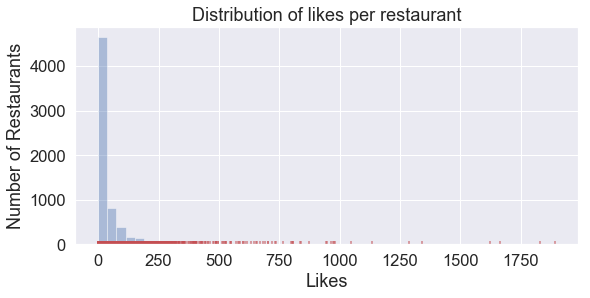

In [6]:
sns.set(style="whitegrid")
plt.figure(figsize=(9,4))
sns.set(font_scale = 1.5)
ax = sns.distplot(a=neighbor_df['Total Likes'],kde=False,rug=True,rug_kws={"color": "r", "alpha":0.5, "linewidth": 2, "height":0.015 })
ax.set_ylabel('Number of Restaurants')
ax.set_xlabel("Likes")
fig = ax.get_figure()
ax.set_title("Distribution of likes per restaurant")
fig.savefig('likes_freq.png',dpi=600,bbox_inches="tight") 


The distribution of likes per restaurant is very right-skewed as can be seen in the histogram and mean of 44.6 and median of 15.0.

What restaurant categories in LA have the most mean likes (again sampled by neighborhood)?

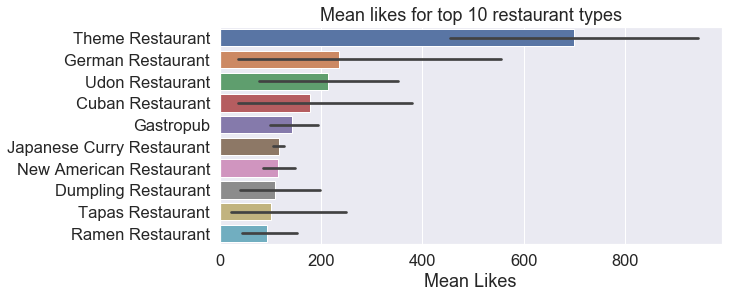

In [7]:
la_likes = neighbor_df[['Venue Category','Total Likes']].groupby('Venue Category').mean()
plot_indices = la_likes.sort_values('Total Likes', ascending=False).head(10).index
plot_data = neighbor_df[['Venue Category','Total Likes']].set_index("Venue Category").loc[plot_indices].reset_index()
plt.figure(figsize=(9,4))
sns.set(font_scale = 1.5)
ax = sns.barplot(y="Venue Category", x="Total Likes", data=plot_data)
ax.set_ylabel('')
ax.set_xlabel("Mean Likes")
ax.set_title("Mean likes for top 10 restaurant types")
fig = ax.get_figure()
fig.savefig('mean_likes.png',dpi=600,bbox_inches="tight") 


Looking at all restaurant types (with std given by error bars), theme and German restaurants have some of the highest mean likes. However, the standard deviations are pretty large with significant overlap between the top 10 restaurants. Given the right skewed distribution we saw above, it would be good to look at boxplots as well. 

First let's filter our results to include restaurant types with at least 10 actual restaurants.

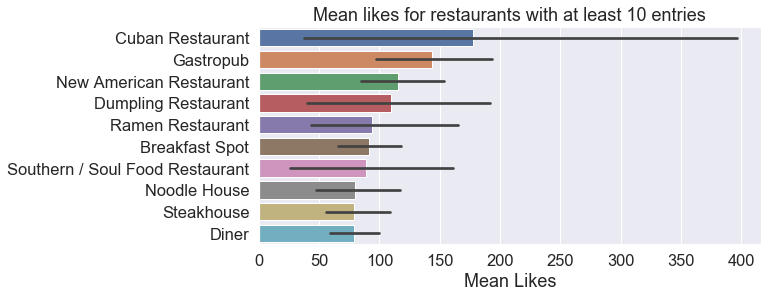

In [8]:
# First group by counts and get idxs of restaurant types with at least 10 restaurants
counts_df = neighbor_df[['Venue Category','Total Likes']].groupby(
    'Venue Category').count().sort_values('Total Likes', ascending=False)
counts_indices = counts_df[counts_df['Total Likes']>=10].index
neighbor_df_filtered = neighbor_df.set_index("Venue Category").loc[counts_indices].reset_index()

# now do the previous analysis on the filtered df
la_likes = neighbor_df_filtered[['Venue Category','Total Likes']].groupby('Venue Category').mean()
plot_indices = la_likes.sort_values('Total Likes', ascending=False).head(10).index
plot_data = neighbor_df_filtered[['Venue Category','Total Likes']].set_index("Venue Category").loc[plot_indices].reset_index()
plt.figure(figsize=(9,4))
sns.set(font_scale = 1.5)
ax = sns.barplot(y="Venue Category", x="Total Likes", data=plot_data)
ax.set_title("Mean likes for restaurants with at least 10 entries")
ax.set_ylabel('')
ax.set_xlabel("Mean Likes")
fig = ax.get_figure()
fig.savefig('mean_likes.png',dpi=600,bbox_inches="tight") 

Now Cuban restaurants seems to be most popular in term of mean likes, followed by gastropubs and new american.

Let's look at the top 10 in terms of median likes and using a boxplot to get an idea for the distribution within types with at least 10 restaurants:

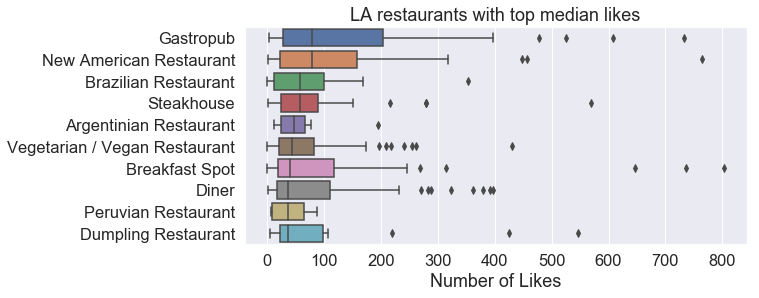

In [9]:
# now do the previous analysis on the filtered df
la_likes = neighbor_df_filtered[['Venue Category','Total Likes']].groupby('Venue Category').median()
plot_indices = la_likes.sort_values('Total Likes', ascending=False).head(10).index
plot_data = neighbor_df_filtered[['Venue Category','Total Likes']].set_index("Venue Category").loc[plot_indices].reset_index()
plt.figure(figsize=(9,4))
sns.set(font_scale = 1.5)
ax = sns.boxplot(y="Venue Category", x="Total Likes", data=plot_data)
ax.set_title("LA restaurants with top median likes")
ax.set_ylabel('')
ax.set_xlabel("Number of Likes")
fig = ax.get_figure()
fig.savefig('mean_likes.png',dpi=600,bbox_inches="tight") 

Gastropub and new American lead the list. It is worth noting that they also had some of the highest mean likes after filtering. Overall, it is clear that most of these categories are right-skewed, with many outliers.

Finally, let's take a look at the geographic distribution of likes for different restaurants.

In [10]:
likes_df = neighbor_df.groupby('Neighborhood').median()[['Total Likes']].reset_index()
likes_df.columns = ['Neighborhood', 'Avg Likes']
polys_likes = likes_df.merge(likes_df,how='outer')
la_geo = r'raw/la_county.json'
poly_gdf = gpd.read_file(la_geo)
poly_gdf.columns = ['Neighborhood', 'slug', 'geometry']
map_df = gpd.GeoDataFrame(likes_df.merge(poly_gdf,how='inner'))
la_coords = [34.0522, -118.2437]#coordinates for LA 
la_map = folium.Map(location=la_coords, zoom_start=10, tiles='cartodbpositron')
la_map.choropleth(
    geo_data=map_df.to_json(),
    fill_opacity=0.8, 
    fill_color='YlGn',
    line_opacity=0.2,
    data=map_df,
    columns=['Neighborhood', 'Avg Likes'],
    key_on='feature.properties.Neighborhood',
    legend_name='Median likes per restaurant on Foursquare',
    highlight=True)
la_map

## Conclusion

 - Restaurants in West Hollywood, Downtown, Santa Monica (and generally on the coast), Pasadena, and Burbank all have a high number of median likes. These seem to be popular areas for restaurants.

 - In terms of restaurant types, those that appear in top 10 lists for median and mean likes are probably good picks for a new restaurant owner. This includes gastropubs, new american, steakhouse, dumpling, breakfast spot, and diners. 

 - There are some restaurant types common in LA that would face serious competition. This includes Mexican restaurants, pizza places, and burger joints. A new business owner starting a restaurant of one of these types should have a good plan for distinguishing themselves from other restaurants.

 - Another interesting couple data points are those for theme restaurants and German restaurants:

In [11]:
neighbor_df[['Venue Category','Total Likes']].set_index("Venue Category").loc[['Theme Restaurant']]

,Total Likes
Venue Category,
Theme Restaurant,943
Theme Restaurant,454


In [12]:
neighbor_df[['Venue Category','Total Likes']].set_index("Venue Category").loc[['German Restaurant']]

,Total Likes
Venue Category,
German Restaurant,981
German Restaurant,107
German Restaurant,24
German Restaurant,9
German Restaurant,250
German Restaurant,41


There are only few examples of theme and German restaurants in the data set, but the likes are generally much higher than the median of 15.0. These may be restaurant types worth pursuing given their scarcity and high number of likes.